In [1]:
import sys
sys.path.append('..')
import pandas as pd

from dataset.cycling_dataset import get_dataset
from utils.feature_extraction import compute_features
from feature_selection.fisher_score import fisher_score

In [2]:
train_dataset = get_dataset(
    file_path_acc='../data/preprocessed/handlebar_acc_train.h5',
    file_path_gyro='../data/preprocessed/handlebar_gyro_train.h5',
)

test_dataset = get_dataset(
    file_path_acc='../data/preprocessed/handlebar_acc_test.h5',
    file_path_gyro='../data/preprocessed/handlebar_gyro_test.h5',
)

In [3]:
# extract features for training data
windows_train, labels_train = train_dataset
X_train = compute_features(windows_train)
y_train = labels_train.astype(str)

# extract features for test data
windows_test, labels_test = test_dataset
X_test = compute_features(windows_test)
y_test = labels_test.astype(str)

100%|██████████| 1219/1219 [00:13<00:00, 87.32it/s]


In [4]:
display(X_train.head())
display(pd.DataFrame(y_train).value_counts())

,mean_acc_x,median_acc_x,mode_acc_x,std_acc_x,var_acc_x,rms_acc_x,mad_acc_x,avg_deriv_acc_x,skew_acc_x,zcr_acc_x,...,corr_acc_y_acc_z,corr_acc_y_gyro_x,corr_acc_y_gyro_y,corr_acc_y_gyro_z,corr_acc_z_gyro_x,corr_acc_z_gyro_y,corr_acc_z_gyro_z,corr_gyro_x_gyro_y,corr_gyro_x_gyro_z,corr_gyro_y_gyro_z
0,0.378119,0.363139,0.330449,0.181374,0.032897,0.419369,0.114129,0.002097,-0.009804,2,...,-0.195621,-0.035493,-0.114655,0.500748,0.026733,0.002792,-0.053192,0.032544,-0.445597,-0.326925
1,0.428359,0.489885,0.363713,0.313348,0.098187,0.530733,0.154848,-0.015027,-1.425947,9,...,-0.236126,0.175051,0.004532,-0.212499,-0.232742,-0.013133,0.075381,0.381453,-0.666427,-0.774744
2,0.286965,0.468665,0.151513,0.638288,0.407411,0.699829,0.282741,0.010196,-0.962586,18,...,-0.237833,0.012461,-0.108101,0.094937,-0.223343,0.037932,0.150593,0.289513,-0.743251,-0.536169
3,0.259104,0.356257,0.151513,0.997736,0.995477,1.030831,0.611363,0.014008,-0.279124,15,...,-0.339374,-0.056609,-0.597142,0.401204,-0.179450,0.139853,0.041356,0.263214,-0.550617,-0.594242
4,0.229121,0.423931,1.220538,1.800692,3.242492,1.815210,1.235917,-0.032279,-0.283232,15,...,-0.337535,0.085830,-0.384860,0.093252,-0.231406,0.131248,0.036833,0.251750,-0.608070,-0.468128


0             
roughness_low     3359
roughness_high    1347
curb               190
Name: count, dtype: int64

## Fisher Score (Supervised feature selection algorithm)

['curb' 'roughness_high' 'roughness_low']


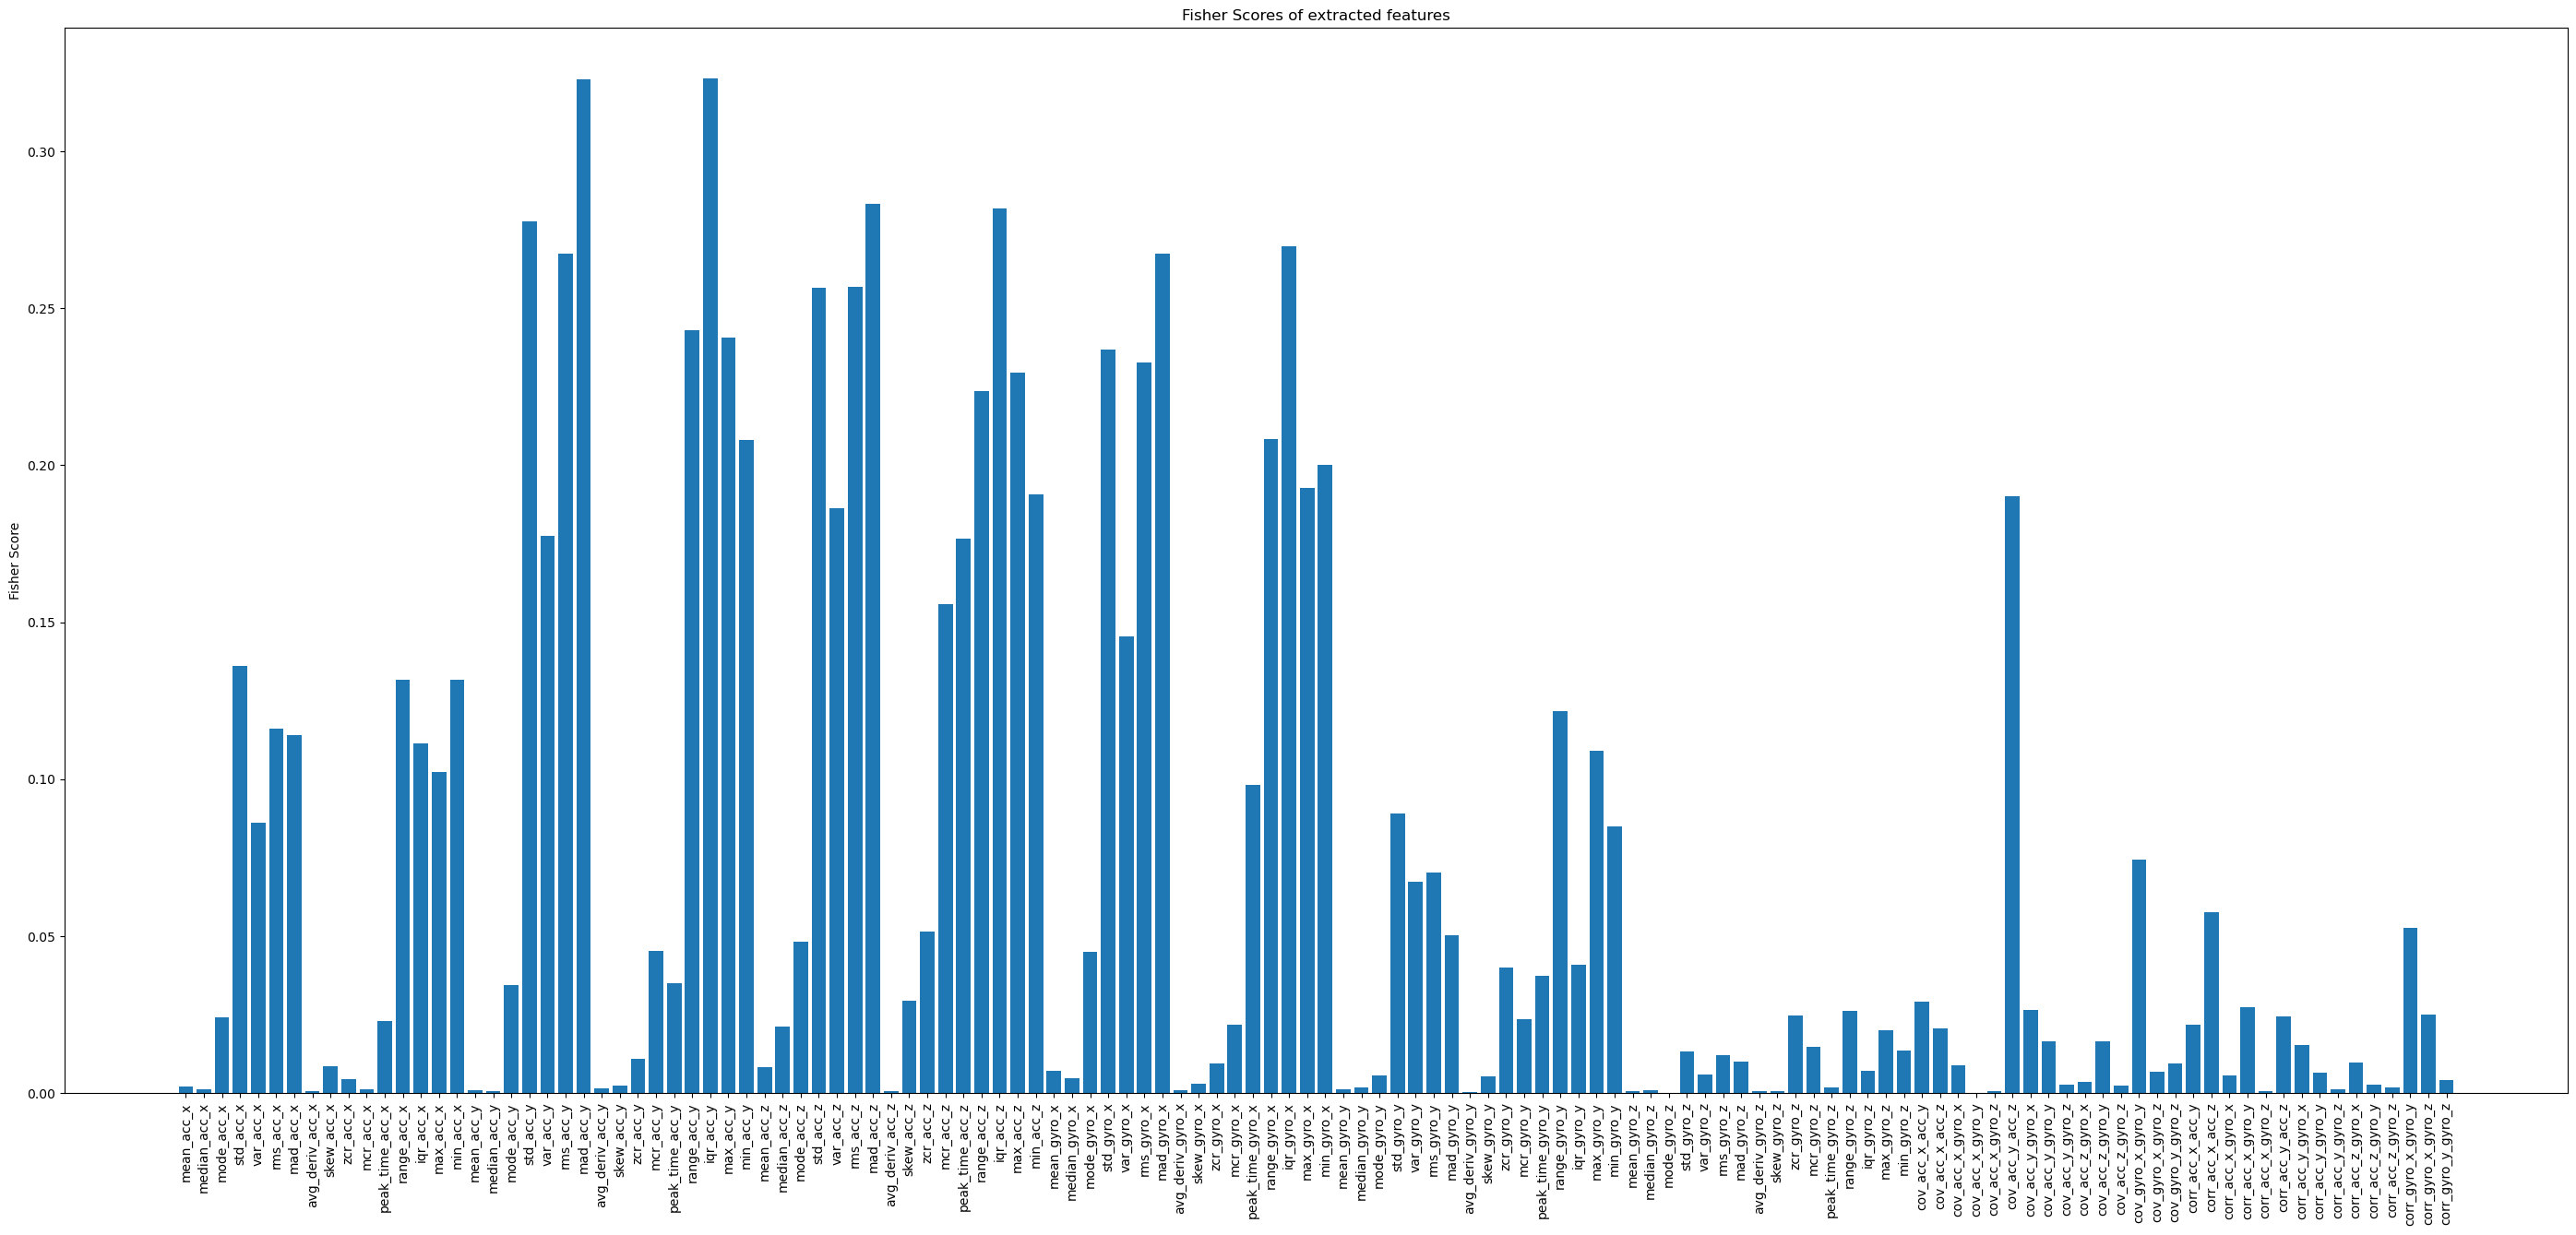

In [5]:
import matplotlib.pyplot as plt

fisher_scores = fisher_score(X_train, y_train)

# bar plot of fisher scores
plt.figure(figsize=(35, 15))
plt.title('Fisher Scores of extracted features')
plt.bar(X_train.columns, fisher_scores)
plt.ylabel('Fisher Score')
plt.xticks(rotation=90)
plt.show()

iqr_acc_y: 0.3231813856097282
mad_acc_y: 0.3229402341646893
mad_acc_z: 0.2831277569028805
iqr_acc_z: 0.2817332899917422
std_acc_y: 0.27763555240110477
iqr_gyro_x: 0.2698590216515131
mad_gyro_x: 0.26744580697173964
rms_acc_y: 0.2673555079724695
rms_acc_z: 0.25669724224330204
std_acc_z: 0.2565964496666152


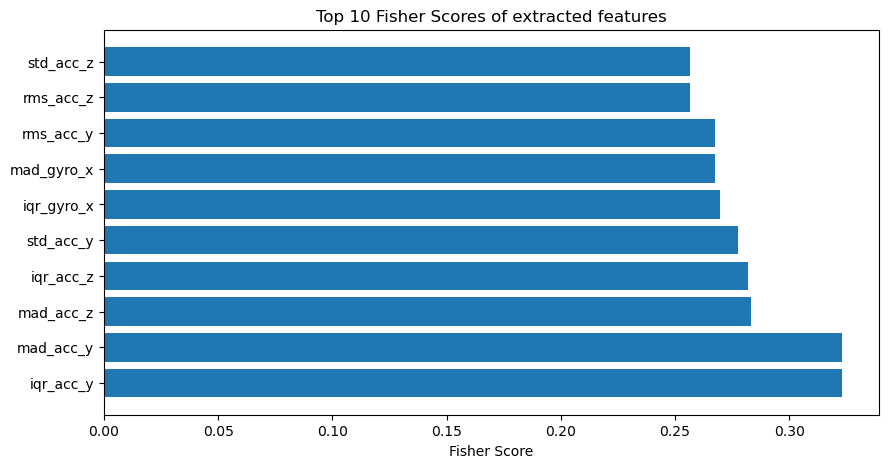

In [6]:
# Print top 10 features
top_10_features = fisher_scores.argsort()[::-1][:10]
for feat in top_10_features:
    print(f'{X_train.columns[feat]}: {fisher_scores[feat]}')

# horizontal bar plot of best 10 features
plt.figure(figsize=(10,5 ))
plt.title('Top 10 Fisher Scores of extracted features')
plt.barh(X_train.columns[top_10_features], fisher_scores[top_10_features])
plt.xlabel('Fisher Score')

plt.savefig('../results/fisher_scores.png')
plt.show()

## PCA (Unsupervised dimensionality reduction algorithm)

In [7]:
from sklearn.decomposition import PCA

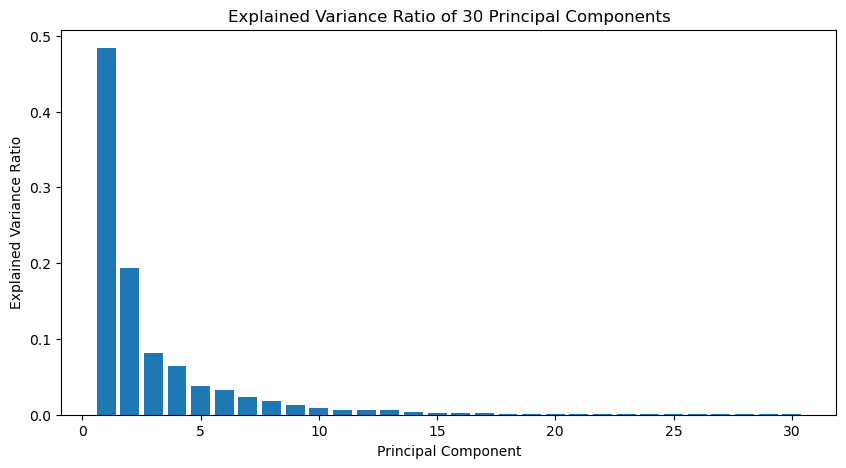

In [8]:
n_components = 30

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)

# plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(range(1, 31), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Explained Variance Ratio of {n_components} Principal Components')
plt.savefig('../results/explained_variance_ratio.png')
plt.show()

In [9]:
# compute reconstruction error
from sklearn.metrics import root_mean_squared_error

X_train_reconstructed = pca.inverse_transform(X_train_pca)
reconstruction_error = root_mean_squared_error(X_train, X_train_reconstructed)
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.17049144426039847


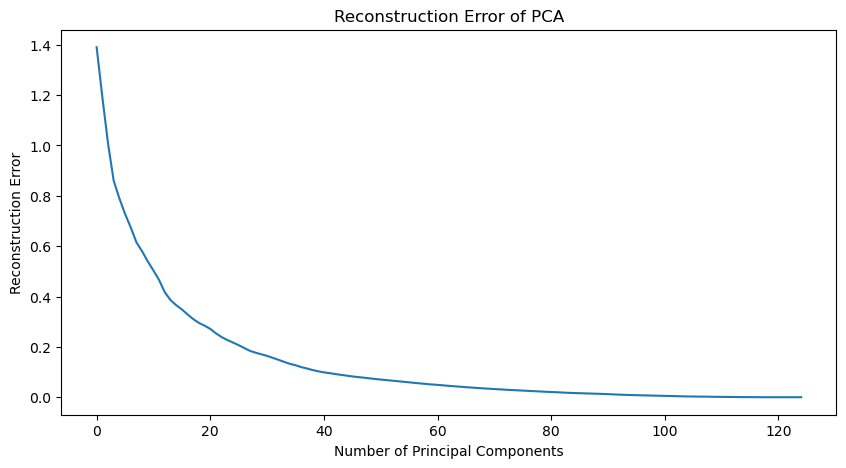

In [10]:
# elbow method to determine optimal number of components
reconstruction_errors = []

for i in range(1, len(X_train.columns)):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_train_reconstructed = pca.inverse_transform(X_train_pca)
    reconstruction_error = root_mean_squared_error(X_train, X_train_reconstructed)
    reconstruction_errors.append(reconstruction_error)

plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors)
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of PCA')
plt.savefig('../results/pca_reconstruction_error.png')
plt.show()

## SVM

In [12]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear", C=1)
svm_selector = RFE(estimator=svc, n_features_to_select=10, step=1)
X_train_svm = svm_selector.fit_transform(X_train, y_train)

print(X_train.columns[svm_selector.support_])

Index(['std_acc_x', 'rms_acc_x', 'std_acc_y', 'rms_acc_y', 'mad_acc_y',
       'iqr_acc_y', 'peak_time_acc_z', 'cov_acc_z_gyro_z', 'corr_acc_x_acc_y',
       'corr_acc_x_acc_z'],
      dtype='object')
